In [4]:
# Importing packages
import gdal
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from osgeo import gdal
import osr
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.insert(0, os.path.abspath(''))
import rasterio
from rasterio.merge import merge
import h5py

from rasterio.plot import show
from pyproj import Proj, transform
import data_processing_helper as dp
import practical_functions as pf
import xarray as xr
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import requests as rq
import shapely
import geoplot as gplt
import glob

plt.style.use('ggplot') # use ggplot style

In [6]:
df_env = pd.read_csv("../Data/Environmental_data/df_env_merged.csv")
# Make geodataframe
df_env['geometry'] = df_env['geometry'].apply(loads)
df_env = pf.make_geo_frame(df_env)
df_env['surveydate'] = pd.to_datetime(df_env['surveydate'], format='%Y-%m')
df_env["year"] = df_env["surveydate"].dt.year
df_env['surveydate'] = df_env['surveydate'].dt.strftime('%Y-%m')

### Shape files

In [4]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')
gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp')
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp')
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp')

# Combining the shapefiles
gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

## Urban Shapefiles
Take the Urban shape file with the locations of the urban centers around the world

In [5]:
urban = gpd.read_file('../Data/Anthropological_data/Urban/grump-v1-urban-ext-polygons-rev02-shp/global_urban_extent_polygons_v1.01.shp')
Urban_survey = urban[(urban["ISO3"] == "AUS") | (urban["ISO3"] == "IDN") | (urban["ISO3"] == "TLS")| (urban["ISO3"] == "SLB")]

# Take the centroid of the polygon geometry
# (lon,lat)
Urban_survey["geometry"] = Urban_survey["geometry"].centroid

In [36]:
# swap to (lat, lon) for te nearest_neighbor 
dp.swap_coordinates(Urban_survey)

116      POINT (-40.849 145.144)
121      POINT (-41.000 145.724)
123      POINT (-41.077 145.898)
130      POINT (-41.145 146.900)
131      POINT (-41.151 144.764)
                  ...           
67684     POINT (-8.150 112.467)
67706     POINT (-8.167 113.433)
67726     POINT (-8.200 113.167)
67746     POINT (-8.317 114.233)
67767     POINT (-8.400 114.266)
Name: geometry, Length: 1626, dtype: geometry

In [38]:
# Find closest urban center to the survey points in meters
df_env_dist = dp.nearest_neighbor(df_env, Urban_survey)

In [39]:
df_env["distance_urban"] = df_env_dist["distance"]

### Marine Protected Areas

In [41]:
marine_prot_points = gpd.read_file("../Data/Anthropological_data/Marine__protection/WDPA_WDOECM_Apr2021_Public_marine_shp-points.shp")
marine_prot_poly = gpd.read_file("../Data/Anthropological_data/Marine__protection/WDPA_WDOECM_Apr2021_Public_marine_shp-polygons.shp")

In [42]:
marine_prot_points = marine_prot_points[(marine_prot_points["ISO3"] == "AUS") | (marine_prot_points["ISO3"] == "IDN") | (marine_prot_points["ISO3"] == "TLS")| (marine_prot_points["ISO3"] == "SLB")]
marine_prot_poly = marine_prot_poly[(marine_prot_poly["ISO3"] == "AUS") | (marine_prot_poly["ISO3"] == "IDN") | (marine_prot_poly["ISO3"] == "TLS")| (marine_prot_poly["ISO3"] == "SLB")]
# let me add a centroid column
marine_prot_poly["centroid"] = marine_prot_poly.centroid

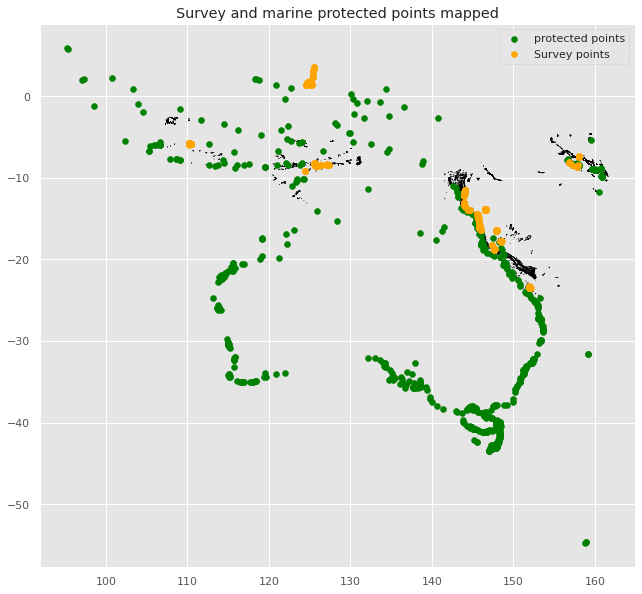

In [15]:
ax = gdf_PAC.plot(edgecolor = "black", figsize  = (20,10), label = "Shapefile");
marine_prot_poly["centroid"].plot(ax = ax, color = "Green")
marine_prot_points.plot(ax = ax, label = "protected points", color = "Green")
df_env.plot(ax = ax, label = "Survey points", color = "orange")
plt.legend();
plt.title("Survey and marine protected points mapped");
marine_prot_poly.rename(columns = {"geometry":"polygon", "centroid":"geometry"}, inplace = True)

In [44]:
marine_prot = pd.concat([marine_prot_poly,marine_prot_points ],ignore_index = True)

In [45]:
# turn multipoint into point
def mult_to_point(df, first_index):
    for ind in range(first_index, len(df)):
        df["geometry"][ind] = Point(df["geometry"][ind][0].x,df["geometry"][ind][0].y)
        
    return df

In [46]:
marine_prot = mult_to_point(marine_prot, 546)

In [47]:
marine_prot.drop(columns = ['WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NAME', 'DESIG',
       'DESIG_ENG', 'DESIG_TYPE', 'IUCN_CAT', 'INT_CRIT', 'MARINE',
       'REP_M_AREA', 'GIS_M_AREA', 'REP_AREA', 'GIS_AREA', 'NO_TAKE',
       'NO_TK_AREA', 'STATUS', 'STATUS_YR', 'GOV_TYPE', 'OWN_TYPE',
       'MANG_AUTH', 'MANG_PLAN', 'VERIF', 'METADATAID', 'SUB_LOC',
       'PARENT_ISO', 'ISO3', 'SUPP_INFO', 'CONS_OBJ', 'polygon'],inplace = True)

In [48]:
# Closest point from marine protected area
dp.swap_coordinates(marine_prot)
marine_prot["geometry"]

0      POINT (-33.316 151.527)
1      POINT (-33.520 151.388)
2      POINT (-18.617 146.495)
3      POINT (-14.670 145.459)
4      POINT (-32.298 133.670)
                ...           
575     POINT (-8.447 157.994)
576     POINT (-5.974 106.693)
577      POINT (-1.170 98.580)
578     POINT (-6.850 115.730)
579     POINT (-5.859 132.571)
Name: geometry, Length: 580, dtype: geometry

In [50]:
df_marine_pro = dp.nearest_neighbor(df_env, marine_prot)

In [52]:
df_env["dist_marine_protection"] = df_marine_pro["distance"]

### Population 

In [53]:
pop = pd.read_csv("../Data/Anthropological_data/Population_pred/Population-EstimatesData.csv")
pop.drop(columns = ["Unnamed: 95","Indicator Code"], inplace = True)
pop = pop[(pop["Country Code"] == "AUS") | (pop["Country Code"] == "IDN") | (pop["Country Code"] == "TLS")| (pop["Country Code"] == "SLB")]
pop = pop[pop['Indicator Name'].str.contains("Population growth|Population, total")]

In [55]:
total_pop = pop[pop["Indicator Name"] == "Population, total"].dropna(axis = 1)
total_growth = pop[pop["Indicator Name"] == "Population growth (annual %)"].dropna(axis = 1)

Text(0.5, 1.0, 'Population growth')

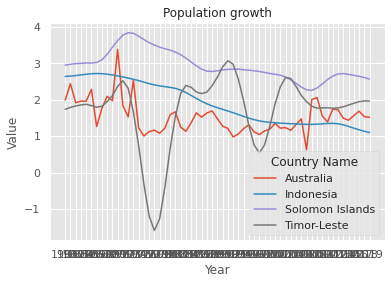

In [56]:
total_growth_melt = total_growth.melt(id_vars=["Country Name", "Country Code", "Indicator Name"], 
        var_name="Year", 
        value_name="Value")
sns.lineplot(x = total_growth_melt["Year"], y = total_growth_melt["Value"], hue = total_growth_melt["Country Name"])
sns.set(rc={'figure.figsize':(13.7,8)})
plt.title("Population growth")

Text(0.5, 1.0, 'Population total')

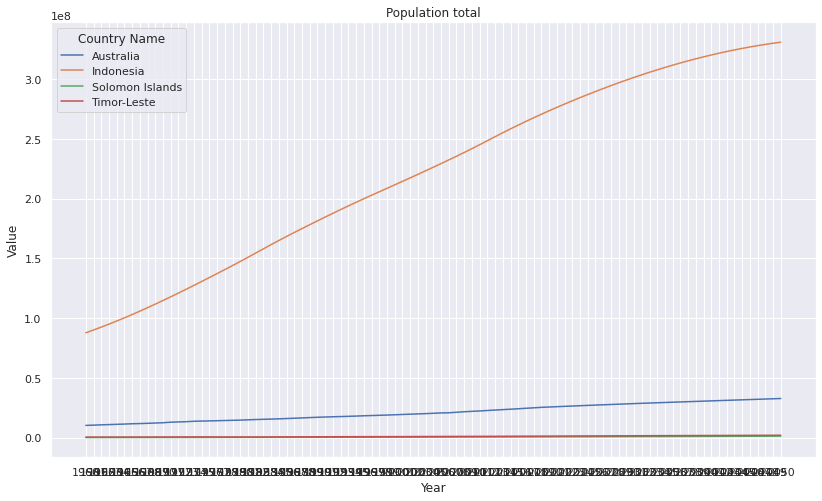

In [57]:
total_pop_melt = total_pop.melt(id_vars=["Country Name", "Country Code", "Indicator Name"], 
        var_name="Year", 
        value_name="Value")
sns.lineplot(x = total_pop_melt["Year"], y = total_pop_melt["Value"], hue = total_pop_melt["Country Name"])
sns.set(rc={'figure.figsize':(13.7,8)})
plt.title("Population total")

In [58]:
total_pop_melt.rename(columns = ({"Country Code": "country", "Year":"year"}), inplace = True)
total_growth_melt.rename(columns = ({"Country Code": "country", "Year":"year"}), inplace = True)

In [59]:
total_pop_melt["year"] = total_pop_melt["year"].astype(int)
total_growth_melt["year"] = total_growth_melt["year"].astype(int)

In [61]:
df_env = pd.merge(df_env,total_pop_melt,on = ["country", "year"]).drop(columns = ["Country Name", "Indicator Name"]).rename(columns = ({"Value":"Population"}))

In [62]:
df_env = pd.merge(df_env,total_growth_melt,on = ["country", "year"]).drop(columns = ["Country Name", "Indicator Name"]).rename(columns = ({"Value":"Population_growth"}))

### Land coverage for Australia and utilities 

In [51]:
gLand = gpd.read_file('../Data/Anthropological_data/Land_commodities/CLUM_Commodities_2020.shp')

In [52]:
gLand["centroid"] = gLand["geometry"].centroid

In [53]:
gLand.rename(columns = {"geometry":"polygon", "centroid":"geometry"}, inplace = True)

In [54]:
dp.swap_coordinates(gLand)
gLand["geometry"]

0         POINT (-35.205 148.989)
1         POINT (-35.346 149.151)
2         POINT (-35.313 149.179)
3         POINT (-35.230 149.193)
4         POINT (-35.225 149.195)
                   ...           
146873    POINT (-41.067 147.884)
146874    POINT (-41.075 147.881)
146875    POINT (-40.987 147.312)
146876    POINT (-41.492 146.577)
146877    POINT (-41.149 145.817)
Name: geometry, Length: 146878, dtype: geometry

In [56]:
closest_agr = dp.nearest_neighbor(df_env, gLand)

In [59]:
closest_agr.rename(columns = {"distance":"dist_agr", "Commod_dsc":"agr_type"},inplace = True)

In [78]:
df_env = pd.concat([df_env,closest_agr[["agr_type","Broad_type", "dist_agr"]]], join = "outer", axis = 1)

In [79]:
col_agr = ["agr_type","Broad_type", "dist_agr"]
df_env.loc[df_env['country'] != "AUS", col_agr] = np.nan

In [80]:
df_env.to_csv("../Data/merged_26_04.csv", index = False)

In [3]:

df_env = pd.read_csv("../Data/merged_26_04.csv")
dp.geo_loads(df_env)
df_env = pf.make_geo_frame(df_env)

### Coaling areas

In [223]:
Coal = rasterio.open("../Data/Anthropological_data/Coaling/global_miningarea_v1_30arcminute.tif")

In [224]:
coal_arr = Coal.read(1)

In [238]:
Coal.crs

CRS.from_epsg(4326)

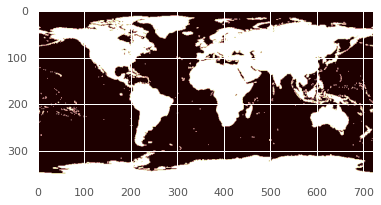

In [225]:
from matplotlib import pyplot
pyplot.imshow(coal_arr, cmap='pink')

In [226]:

coords = np.where(coal_arr > 0)

out_trans = nightlights_2012_2019.transform
coal_values = coal_arr[coords]
# keep indices of coordinates with one
lon_ind = list(coords[0])
lat_ind = list(coords[1])
# Find the (x,y) coordinates in the raster file
coordinate = rasterio.transform.xy(out_trans,lon_ind, lat_ind)
lon_lat_coords = np.dstack((coordinate[0],coordinate[1]))

In [228]:
lon_lat_coords = lon_lat_coords[0, :, :]

In [229]:
# Make a dataframe with the coordinates
df_coal = pd.DataFrame(lon_lat_coords[:,0],lon_lat_coords[:,1]).reset_index()

In [230]:
df_coal.rename(columns = {"index":"lat", 0:"lon"}, inplace = True)

In [231]:

# Make a geodataframe with the coordinates
gdf_coal = gpd.GeoDataFrame(
    df_coal, geometry=gpd.points_from_xy(df_coal.lat, df_coal.lon))
gdf_coal["mine_area_per_call"] = coal_values

In [232]:
df_near = dp.nearest_neighbor(df_env, gdf_coal)
df_env["mine_area_per_cell"] = df_near["mine_area_per_call"]
df_env["distance_to_mine_area"] = df_near["distance"]

# Nightlights 
Yearly - 2012/2018
- avg_rad within 15 km 

In [140]:
list_dates = ["2012", "2013", "2014", "2015", "2016", "2017", "2018"]

In [134]:
def nighlight(df_env, list_dates):
    
    for date in list_dates:
        nightlights = rasterio.open(format(f"../Data/Anthropological_data/NightLight/VIIRS_15km_{date}.tif"))
        arr = nightlights.read(1)
        coords = np.where((~np.isnan(arr)) & (arr > 0))
        out_trans = nightlights.transform
        night_values = arr[coords]
        
        # keep indices of coordinates with no nans
        lon_ind = list(coords[0])
        lat_ind = list(coords[1])
        # Find the (x,y) coordinates in the raster file
        coordinate = rasterio.transform.xy(out_trans,lon_ind, lat_ind)
        lon_lat_coords = np.dstack((coordinate[0],coordinate[1]))
        lon_lat_coords = lon_lat_coords[0, :, :]
        # Make a dataframe with the coordinates
        df_night = pd.DataFrame(lon_lat_coords[:,0],lon_lat_coords[:,1]).reset_index()
        df_night.rename(columns = {"index":"lat", 0:"lon"}, inplace = True)

# Make a geodataframe with the coordinates
        gdf_night = gpd.GeoDataFrame(
            df_night, geometry=gpd.points_from_xy(df_night.lat, df_night.lon))


        gdf_night["nightlight"] = night_values
        df_near = dp.nearest_neighbor(df_env, gdf_night)
        df_env[format(f"nigh_avg_{date}")] = df_near["nightlight"]
        df_env[format(f"nigh_avg_distance_{date}")] = df_near["distance"]
        
        
        
        
    

In [146]:
nighlight(df_env, list_dates)

In [149]:
filter_col_distance = [col for col in df_env if col.startswith('nigh_avg_distance')]

### Fishing

In [185]:
import pyproj as proj
def fishing_dist(df_env, list_dates, min_dist = 50000):
    for date in list_dates:
        print(date)
        path = format(f"../Data/Anthropological_data/Fishing/fleet-daily-csvs-100-v2-{date}")
        all_files = glob.glob(path + "/*.csv")
        li = []

        for filename in all_files:
            df = pd.read_csv(filename, index_col=None, header=0)

            df = df[(((df['cell_ll_lon'].between(110,160)) & (df['cell_ll_lat'].between(-24,4)) & (df['fishing_hours'] != 0)))]

            li.append(df)
        frame = pd.concat(li, axis=0, ignore_index=True)
        frame.rename(columns = {"cell_ll_lat":"lat", "cell_ll_lon":"lon"},inplace = True)
        gframe = gpd.GeoDataFrame(
        frame, geometry=gpd.points_from_xy(frame.lat, frame.lon), crs = "WGS84")
        

        # setup your projections
        crs_wgs = proj.Proj(init='epsg:4326') 
        crs_bng = proj.Proj(init='epsg:3112') # use a locally appropriate projected CRS

        # then cast your geographic coordinate pair to the projected system
        x_fish, y_fish = proj.transform(crs_wgs, crs_bng, frame["lon"][:].to_list(), frame["lat"][:].to_list())
        
        print(format(f"year {date} transform done"))
        # First round 
        
        
        x_env, y_env = proj.transform(crs_wgs, crs_bng, df_env["lon"][:].to_list(), df_env["lat"][:].to_list())
        df_env["x"] = x_env
        df_env["y"] = y_env
        genv = df_env.copy()
        genv = gpd.GeoDataFrame(
                    genv, geometry=gpd.points_from_xy(genv.x, genv.y))
            
        frame["x"] = x_fish
        frame["y"] = y_fish
        
        gxframe = gpd.GeoDataFrame(
    frame, geometry=gpd.points_from_xy(frame.x, frame.y))
        print(format(f"year {date} made geoDataFrame"))
        
        df_distance_fishing = genv.geometry.apply(lambda g: gxframe.distance(g))
        print(format(f"year {date} computed distance"))
        dmin = min_dist # 100 km#(df_fi).min().std()
        df_distance_fishing.to_csv(format(f"../Data/fishing_{date}_inter.csv"), index = False)
        
        # Fill weight = 1 if within 50km else 0
        df_distance_fishing[~df_distance_fishing[df_distance_fishing < dmin].isnull()] = 1
        df_distance_fishing[df_distance_fishing != 1] = 0
        print(format(f"year {date} finished assigning"))
        
        fish_hours = gxframe["hours"]
        hours_ = df_distance_fishing *fish_hours
        df_env[format(f"fish_hours_{date}")] = hours_.sum(axis = 1)
        
    
    
    
    

In [196]:
# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [110, 160]

# 50 km arund survey point I say yes, else no
min_dist = 50000
list_dates_ = ["2012", "2014", "2016", "2017"]
# Could not run 2018 due to heavy file 
#list_dates_ = ["2012", "2014", "2016", "2017", "2018"]

In [192]:
fishing_dist(df_env, list_dates_)

### Land Coverage
Data-set is huge, thus changing to NETCDF and merging there is better as it did not accept merging the tiff files. Did not work and using NetCDF is HUGE as well...
https://land.copernicus.eu/global/sites/cgls.vito.be/files/products/CGLOPS1_PUM_LC100m-V2.0_I2.20.pdf
Labels
- 10 - Forest/tree cover
- 20 - Shrub
- 30 - Herbaous vegetation
- 40 - Cultivated and managed vegetation/agriculture
- 50 - Urban/built up
- 60 - Bare/sparse vegetation
- 70 - Snow and Ice
- 80 - Open water
- 90 - Wetland



Because of the size. I use a 5km rescaling thanks to Google Earth Engine  

In [157]:
filename = "../Data/Anthropological_data/Land_cover/Agriculture_cover_google_masked_5km.tif"
input_raster = gdal.Open(filename)
for epsg in ["EPSG:4326"]:
    gdal.Warp('../Data/Anthropological_data/Land_cover/Agriculture_cover_google_masked_5km' + epsg + '.tif', input_raster, dstSRS=epsg)

In [158]:
# Array
LC_5km = rasterio.open('../Data/Anthropological_data/Land_cover/Agriculture_cover_google_masked_5kmEPSG:4326.tif')
arr = LC_5km.read(1)

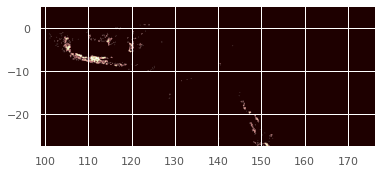

<AxesSubplot:>

In [159]:
from matplotlib import pyplot
from rasterio.plot import show
show(arr, cmap='pink',transform=LC_5km.transform)

In [ ]:
rc = np.transpose(np.nonzero(arr==1))
lonlat = [LC_5km.xy(row, col) for row, col in rc]

# Use itterator to separate lat,lon in list file
a,b = map(itemgetter(0),lonlat), map(itemgetter(1),lonlat)
lon,lat = map(list,zip(*lonlat))

In [ ]:
# Make a dataframe with the coordinates
df_LC = pd.DataFrame(lat,lon).reset_index()

df_LC.rename(columns = {"index":"lon", 0:"lat"}, inplace = True)
# Make a geodataframe with the coordinates
gdf_LC = gpd.GeoDataFrame(
    df_LC, geometry=gpd.points_from_xy(df_LC.lat, df_LC.lon))

# dataframe with closest agricultural land 
df_near = dp.nearest_neighbor(df_env, gdf_LC)

df_env["distance_agr_land"] = df_near["distance"]

df_env.to_csv("../Data/merged_30_04.csv", index = False)